# AI Blog Writer with Multi-Style Generation  

This notebook walks through exploring transformer architecture and prompt engineering using the Llama 3.1 8B Instruct model.  

## Notebook Highlights:  
- Load the Llama 3.1 model with 4-bit quantization  
- Explore its layers, attention mechanisms, and parameters  
- Use prompt engineering to generate content in five different writing styles  
- Build an interactive Gradio app for generating blogs  

**Model used:** `meta-llama/Llama-3.1-8B-Instruct` (8.03B parameters)

## Step 1. Setup and Installation of Libraries

In [32]:
!pip install transformers accelerate torch gradio bitsandbytes matplotlib huggingface_hub

In [33]:
import gradio as gr
from google.colab import userdata
from huggingface_hub import login
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, TextStreamer
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import gc

## Step 2. Loading the Model and Exploring the Architecture

In [34]:
MODEL = "meta-llama/Llama-3.1-8B-Instruct"
hf_token=userdata.get('HF_TOKEN')
login(hf_token, add_to_git_credential=True)

quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4"
)

tokenizer = AutoTokenizer.from_pretrained(MODEL, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    MODEL,
    device_map="auto",
    quantization_config=quant_config
)

print(f"Model loaded successfully on {model.device}")

tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

Model loaded successfully on cuda:0


In [35]:
#Looking at the model's architecture
print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((409

In [44]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("MODEL STATISTICS:")
print(f"Total Parameters= {total_params:,}")
#this will print 4.5B parameters even though the model has 8B because of 4-bit quantization. It's the same model, just compressed.
print(f"Trainable Parameters= {trainable_params:,}")
print(f"Vocabulary Size= {tokenizer.vocab_size:,}")

config = model.config

print("\nKEY ARCHITECTURE STATISTICS:")
print(f"Hidden Size= {config.hidden_size}")
print(f"Number of Layers= {config.num_hidden_layers}")
print(f"Attention Heads= {config.num_attention_heads}")
print(f"FFN Intermediate Size= {config.intermediate_size}")
print(f"Max Sequence Length= {config.max_position_embeddings}")
print(f"Vocabulary Size= {config.vocab_size:,}")

MODEL STATISTICS:
Total Parameters= 4,540,600,320
Trainable Parameters= 1,050,939,392
Vocabulary Size= 128,000

KEY ARCHITECTURE STATISTICS:
Hidden Size= 4096
Number of Layers= 32
Attention Heads= 32
FFN Intermediate Size= 14336
Max Sequence Length= 131072
Vocabulary Size= 128,256


### Visualization 1: Parameter Distribution Across Model Components

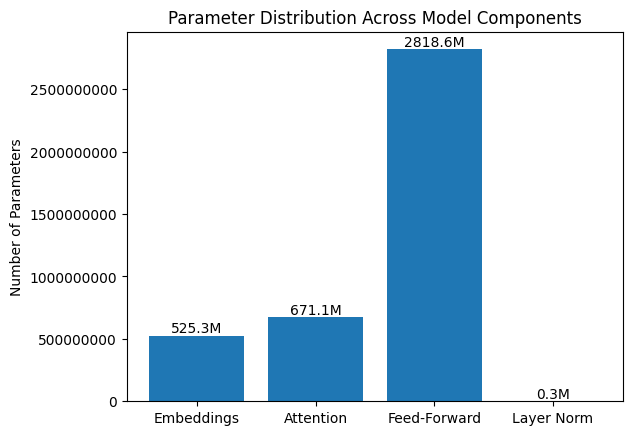

Total: 4,015,259,648 parameters


In [45]:
embed_params = model.model.embed_tokens.weight.numel()

sample_layer = model.model.layers[0]
attn_params = sum(p.numel() for p in sample_layer.self_attn.parameters()) * config.num_hidden_layers
ffn_params = sum(p.numel() for p in sample_layer.mlp.parameters()) * config.num_hidden_layers
ln_params = (sum(p.numel() for p in sample_layer.input_layernorm.parameters()) +
             sum(p.numel() for p in sample_layer.post_attention_layernorm.parameters())) * config.num_hidden_layers

params = {"Embeddings": embed_params, "Attention": attn_params, "Feed-Forward": ffn_params, "Layer Norm": ln_params}

bars =plt.bar(params.keys(), params.values())
plt.bar_label(bars, labels=[f"{v/1e6:.1f}M" for v in params.values()])
plt.ylabel("Number of Parameters")
plt.title("Parameter Distribution Across Model Components")
plt.ticklabel_format(style='plain', axis='y')
plt.show()

print(f"Total: {sum(params.values()):,} parameters")

### Visualization 2: Single Layer Parameter Breakdown

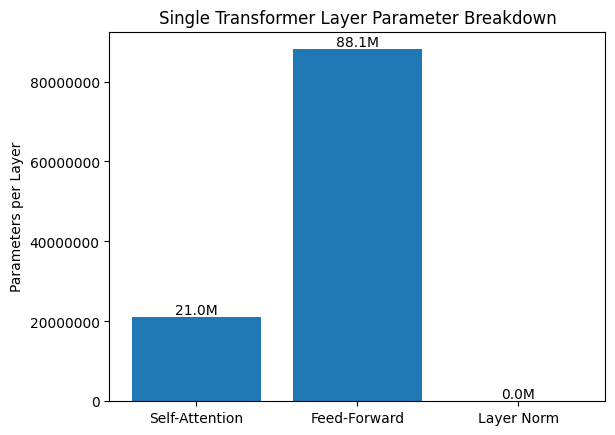

Parameters per layer: 109,060,096
Total for 32 layers: 3,489,923,072


In [46]:
attn_per_layer = sum(p.numel() for p in sample_layer.self_attn.parameters())
ffn_per_layer = sum(p.numel() for p in sample_layer.mlp.parameters())
ln_per_layer = (sum(p.numel() for p in sample_layer.input_layernorm.parameters()) +
                sum(p.numel() for p in sample_layer.post_attention_layernorm.parameters()))

layer_params = {"Self-Attention": attn_per_layer, "Feed-Forward": ffn_per_layer, "Layer Norm": ln_per_layer}

bars = plt.bar(layer_params.keys(), layer_params.values())
plt.bar_label(bars, labels=[f"{int(v)/1e6:.1f}M" for v in layer_params.values()])
plt.ylabel("Parameters per Layer")
plt.title("Single Transformer Layer Parameter Breakdown")
plt.ticklabel_format(style='plain', axis='y')
plt.show()

total_per_layer = sum(layer_params.values())
total_all_layers = total_per_layer * config.num_hidden_layers
print(f"Parameters per layer: {total_per_layer:,}")
print(f"Total for {config.num_hidden_layers} layers: {total_all_layers:,}")

### Visualization 3: Next Token Predictor

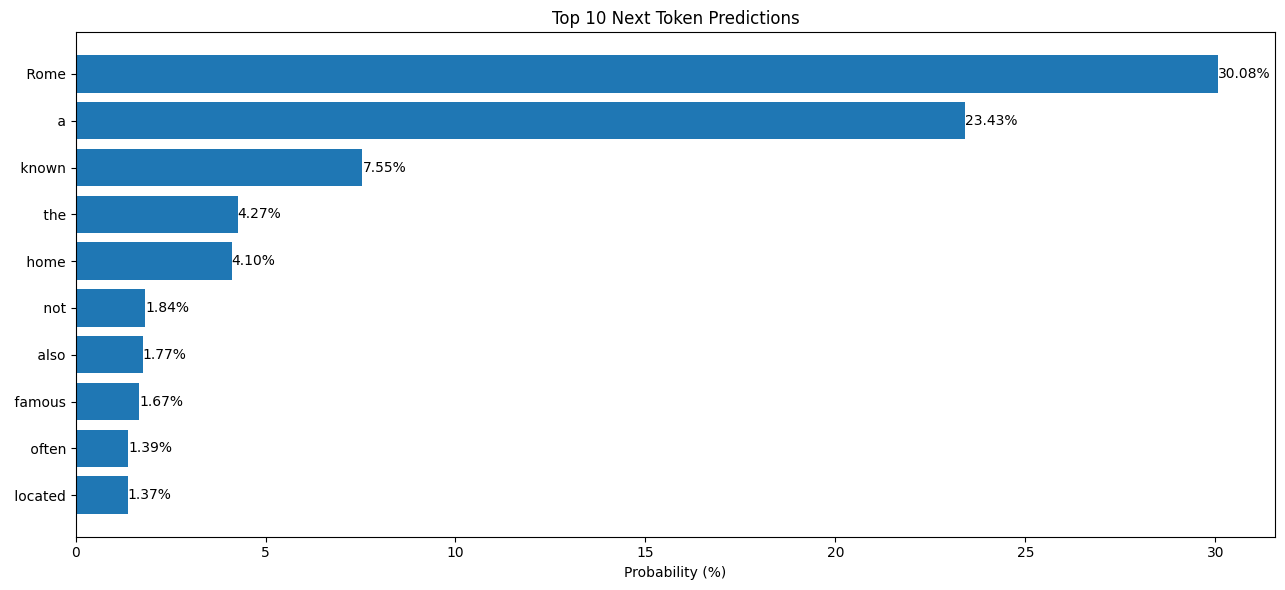

In [47]:
prompt = "The capital of Italy is"

inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits

next_token_logits = logits[0, -1, :]
probs = F.softmax(next_token_logits, dim=-1)

top_k = 10
top_probs, top_indices = torch.topk(probs, top_k)

tokens = [tokenizer.decode([idx]) for idx in top_indices]
probs_percent = [p.item() * 100 for p in top_probs]

fig = plt.figure(figsize=(13, 6))
bars = plt.barh(tokens[::-1], probs_percent[::-1])
plt.xlabel('Probability (%)')
plt.title(f'Top {top_k} Next Token Predictions')
plt.bar_label(bars, fmt="%.2f%%")
plt.tight_layout()
plt.show()

In [48]:
#generation test
test_prompt = "Write an paragraph on the topic of AI"
system_prompt = "You are a creative writer that writes anything from paragraphs to entire blogs"
messages = [
    {"role": "system", "content": system_prompt},
    {"role": "user", "content": test_prompt}
]

inputs = tokenizer.apply_chat_template(messages, add_generation_prompt=True,return_tensors="pt").to(model.device)

outputs = model.generate(inputs,max_new_tokens=300)
result = tokenizer.decode(outputs[0])
content = result.split("assistant<|end_header_id|>")[1]

print(content)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.




**The Dawn of a New Era: Unveiling the Mystique of Artificial Intelligence**

As we navigate the uncharted territories of the 21st century, one phenomenon has been making waves, captivating the imagination of scientists, philosophers, and the general public alike – Artificial Intelligence (AI). This revolutionary technology, born from the marriage of human ingenuity and computational prowess, has been steadily evolving, transforming the way we live, work, and interact with one another. With AI, machines can now learn, reason, and adapt at an unprecedented pace, rendering them capable of tackling complex tasks that were once the exclusive domain of humans. From the intuitive chatbots that assist us in our daily lives to the sophisticated algorithms that drive self-driving cars, AI has become an integral part of our modern landscape, poised to redefine the boundaries of innovation and propel us toward a future where the distinction between man and machine becomes increasingly blurred. 

## 4. Prompt Engineering - Style Templates

In [53]:
STYLE_PROMPTS = {
    "Technical/Professional": """Write a clear and professional blog post on the topic: {topic}
    Keep the language and tone professional, use technical terms correctly, and structure the content so it makes sense logically and with relevant details""",

    "Casual/Conversational": """Write a casual blog post on the topic: {topic}
    Keep the tone friendly and conversational, use simple words and give relatable examples like you're talking to your friend""",

    "Academic/Research": """Write an academic blog post on the topic: {topic}
    Use formal language, present nuanced analysis, and maintain high standards of intellectuality and stick to sound logic and evidence""",

    "Marketing/Persuasive": """Write an persuasive blog post on the topic: {topic}
    Focus on getting the reader engaged, highlight the benefits, and use a attention captivating tone to create excitement""",

    "Storytelling/Creative": """Write a creative blog post on the topic: {topic}
    Use clear descriptions, tell a story and focus on making the content engaging and imaginative"""
}

In [55]:
def generate_blog(topic, style, max_length=500):
    user_prompt = STYLE_PROMPTS[style].format(topic=topic)
    system_prompt = f"You write blogs with maximum word count of {max_length}. Always respond only with the complete blog content. Do not include any added explanations, notes, or extra text. Only the blog itself"
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt}
    ]
    inputs = tokenizer.apply_chat_template(messages, add_generation_prompt=True, return_tensors="pt").to(model.device)

    outputs = model.generate(inputs, max_new_tokens=(max_length*2))
    result = tokenizer.decode(outputs[0])
    content = result.split("assistant<|end_header_id|>")[1]
    content = content.split("<|eot_id|>")
    blog = content[0]
    return blog

topic = "The impact of social media on society"
style = "Casual/Conversational"

blog_post = generate_blog(topic, style)
print(blog_post)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.




**The Social Media Effect: How Our Online Lives Are Shaping Society**

Hey friends, let's talk about something that's probably on your mind a lot these days: social media. We're all guilty of scrolling through our feeds, comparing our lives to others, and feeling like we're not doing enough. But have you ever stopped to think about how social media is actually impacting our society?

From the way we communicate to the way we spend our time, social media is changing the game. And while it's not all bad, we need to acknowledge the potential downsides and make some changes.

**The Good Stuff**

Let's start with the positives. Social media has connected us in ways we never thought possible. We can stay in touch with friends and family who live far away, join communities of people with similar interests, and even find support groups for mental health. It's amazing to think about how much more connected we are today than we were just a decade ago.

Take, for example, the rise of online act

## 5. Interactive Gradio Interface

In [59]:
def generate_blog(topic, style, max_length=500):
    if not topic.strip():
        return "Please enter a topic!"

    system_prompt = (
        f"You write blogs with a maximum word count of {max_length}. "
        f"Always respond only with the complete blog content in **Markdown format**. "
        f"Do not include any added explanations, notes, or extra text. Only the blog itself."
    )
    user_prompt = STYLE_PROMPTS[style].format(topic=topic)
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt}
    ]
    inputs = tokenizer.apply_chat_template(messages, add_generation_prompt=True, return_tensors="pt").to(model.device)

    outputs = model.generate(inputs, max_new_tokens=(max_length*2))

    result = tokenizer.decode(outputs[0])
    content = result.split("assistant<|end_header_id|>")[1]
    blog = content.split("<|eot_id|>")[0].strip()
    return blog

with gr.Blocks() as demo:
    with gr.Row():
        with gr.Column(scale=1):
            topic_input = gr.Textbox(label="Blog Topic", placeholder="Enter blog topic...")
            style_dropdown = gr.Dropdown(list(STYLE_PROMPTS.keys()), value="Casual/Conversational", label="Style")
            length_input = gr.Number(value=500, label="Max Word Count")
            generate_btn = gr.Button("Generate Blog")

        with gr.Column(scale=2):
            output_md = gr.Markdown(label="Generated Blog")

    generate_btn.click(generate_blog, inputs=[topic_input, style_dropdown, length_input], outputs=output_md)

demo.launch(inbrowser=True)

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c5f9ec226bc57ec8d6.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
